 从exRNA测序数据中鉴定癌症的生物标志物

## 背景介绍
（adapt from Young Lee）

在多种体液中，如血清、唾液以及尿液等，可以检测到一类非侵入性细胞外 RNA (extracellular RNA, exRNA)。诸如环状RNA (circular RNA)等这类具有空间结构的 RNA 分子，能够在血浆中稳定存在。这些从细胞分泌出的 exRNA 通常由微囊泡 (microvesicles)、外泌体(exosome) 包裹，或者与 RBP 密切结合形成 RNP 复合体。因为这些分子由于具备类细胞膜结构和蛋白质的保护，加上某些 RNA 具有特定的结构，exRNA 在多种体液 (血清、唾液、尿液等) 中可以抵抗体液中 RNase 的降解，从而稳定存在。exRNA 包括的类型很多，例如 miRNA，Y RNA, circRNA，lncRNA 等，每种又有不同的加工、剪切和修饰产物，这种多样性为更 好的临床检验带来了新的期望。这些 exRNA 可以成为一类有效的生物标志物，服务于人体健康状况检测和疾病的诊断，如癌症的早期诊断、肿瘤生长状况监测、以及预后辅助诊断。

本Quiz依托于Lulab现有的一些研究结果，希望读者通过生物信息学方法，尝试使用一些机器学习方法，发现和研究与癌症发生发展相关的新型体液胞外RNA (extracellular RNA，exRNA)生物标志物，并应用于几种国内高致死癌症的早期诊断和预后辅助治疗。我们将在癌症病人体液 (如血液)中的游离、微囊泡、外泌体、RNP 等不同组分中发现和鉴定标志癌症发生发展的新型 exRNA，构建模型，最终建立一个具有更高精准度和重复性的无创检验癌症（尤其是早期癌症）的方法。


### 总体流程图
![pngs](plots/wholepipe.png)

### 主要目标
利用构建出的expression matrix，分别对Colorectal Cancer vs Healthy Control和Prostate Cancer vs Healthy Control建立分类模型，找出稳健的可以区分癌症和正常样本的Feature，并进行相关分析。
![pngs](plots/expression_matrix_demo.png)

## 数据介绍
我们使用的[数据](https://www.nature.com/articles/srep19413)主要包括两种癌症和正常人样本，其中Colorectal Cancer, Prostate Cancer和Healthy Control的样本数量分别为99，36和50。数据存放公共目录为cnode服务器的`/BioII/chenxupeng/student/`目录。

- `data`目录下为已经建好的expression matrix，相应的label和annotation
- 另外的文件夹中存放的文件是读者用于自己完成对五个正常人样本`Sample_N1, Sample_N7, Sample_N13, Sample_N19, Sample_N25`进行mapping和创建expression matrix等操作的。

### mapping相关文件
路径：包括`/BioII/chenxupeng/student/`目录下的`hg38_index`, `raw_data`, `RNA_index`文件夹。

| data | path |
| :--- | :--- |
| `raw data` | `/BioII/chenxupeng/student/raw_data/*.fastq` |
| `hg38` | `/BioII/chenxupeng/student/hg38_index/GRCh38.p10.genome.fa` |
| `gtf` | `/BioII/lulab_b/shared/genomes/human_hg38/anno/gtf` |
| `RNA index` | `/BioII/chenxupeng/student/RNA_index/` |


具体内容参考[**mapping指南**](#mappinghelp)

### expression matrix
路径：`/BioII/chenxupeng/student/data/expression_matrix/`

expression matrix每一行为一个feature，每一列为一个样本，其中我们去掉了`Sample_N13, Sample_N19, Sample_N25`三个样本的相应数据，需要读者自己完成mapping和构建expression matrix（[详见3.2 Expression Matrix](#expressmatrix)）。

In [1]:
import pandas as pd
import numpy as np
scirepount = pd.read_table('data/expression_matrix/GSE71008.txt',sep=',',index_col=0)

In [2]:
scirepount.iloc[:,:5].head()

,Sample_1S10,Sample_1S11,Sample_1S12,Sample_1S13,Sample_1S14
transcript,,,,,
ENST00000473358.1|MIR1302-2HG-202|1544,0,0,0,0,0
ENST00000469289.1|MIR1302-2HG-201|843,0,0,0,0,0
ENST00000466430.5|AL627309.1-201|31638,0,0,0,0,0
ENST00000471248.1|AL627309.1-203|18221,0,0,0,0,0
ENST00000610542.1|AL627309.1-205|12999,0,0,0,0,0


In [3]:
scirepount.shape

(89619, 188)

### sample labels
路径：`/BioII/chenxupeng/student/data/labels`

In [4]:
scirep_samplenames = pd.read_table('data/labels/scirep_classes.txt',delimiter=',' , index_col=0)

In [5]:
scirep_samplenames.head()

,label
sample_id,
Sample_1S3,Colorectal Cancer
Sample_1S6,Colorectal Cancer
Sample_1S9,Colorectal Cancer
Sample_1S12,Colorectal Cancer
Sample_1S15,Colorectal Cancer


In [6]:
delete_sample = ['Sample_N1','Sample_N7','Sample_N13','Sample_N19','Sample_N25']
check_sample = ['Sample_N1','Sample_N7']

In [7]:
np.unique(scirep_samplenames['label'],return_counts=True)

(array(['Colorectal Cancer', 'Healthy Control', 'Pancreatic Cancer',
        'Prostate Cancer'], dtype=object), array([99, 50,  6, 36]))

### other annotations
路径：`/BioII/chenxupeng/student/data/other_annotations`
#### gene annotation
可以通过feature的transcript id找到feature的transcript_nama, gene_type等信息

In [8]:
geneannotation = pd.read_table('data/other_annotations/transcript_anno.txt')

In [9]:
geneannotation.iloc[:,:5].head()

,chrom,start,end,name,score
0,chr1,14629,14657,piR-hsa-18438,0
1,chr1,17368,17436,ENSG00000278267.1,0
2,chr1,18535,18563,piR-hsa-7508,0
3,chr1,26805,26836,piR-hsa-23387,0
4,chr1,29553,31097,ENSG00000243485.5,0


#### batch信息
batch信息记录了对不同样本采取的不同实验条件，包括处理时间，处理材料的规格差异等，可能会造成同类样本的较大差异，称为batch effect。

对于exoRBase数据，每一种癌症样本均来自不同的实验室，因此其batch与样本类别重合。对于scirep数据和hcc数据，batch信息如下：

In [10]:
scirepbatch = pd.read_csv('data/other_annotations/scirep_batch.txt',index_col=0)

In [11]:
scirepbatch.head()

,RNA Isolation batch,library prepration day,gel cut size selection
Sample_1S1,2,22,7
Sample_1S2,2,22,8
Sample_1S3,2,22,1
Sample_2S1,2,22,2
Sample_2S2,2,22,3


### RNA type 统计信息

In [12]:
scireprnastats = pd.read_csv('data/other_annotations/scirep_rna_stats.txt',index_col=0)

In [13]:
scireprnastats.iloc[:,:5].head()

,Sample_1S10,Sample_1S11,Sample_1S12,Sample_1S13,Sample_1S14
Y_RNA,88835,127497,145142,90106,105377
cleanN,9034303,10963430,11077344,10262615,11065325
hg38other,1462269,2044478,2624270,1476586,1806268
libSizeN,11362190,13437632,13905951,12271219,13619701
lncRNA,26733,38346,35639,25523,31489


## Quiz具体要求
请读者使用我们提供的数据，完成以下工作：

- 六个主要步骤：
    - 1.完成五个样本的**mapping**工作，并**统计相关的比例和长度信息**
    - 2.完成五个样本的**expression matrix构建**
    - 3.完成**数据分析和质量控制**工作
    - 4.完成**预处理**工作
    - 5.完成**特征选择和特征筛除工作**并汇报挑选出的feature。
    - 6.完成**模型评估与feature解释**。


- 中期报告要求（13周结束时提交）：完成1.mapping, 2.expression matrix, 3.数据分析和质量控制, 4.预处理和5.基础要求部分，参照教程示例绘制相应的图，提交一份工作概述，。

- 期末报告要求：提交一份**工作报告**，中英文不限，同时提交**源代码**。

> 参考文献：
>
> [LncRNA proﬁle study reveals a three-lncRNA signature associated with the survival of patients with oesophageal squamous cell carcinoma.pdf](https://www.ncbi.nlm.nih.gov/pubmed/24522499)

### Mapping
完成五个样本`Sample_N1, Sample_N7, Sample_N13, Sample_N19, Sample_N25`的mapping和RNA ratio与length的统计工作。


具体步骤请参考[*Mapping指南*](#mappinghelp)

**Inputs**

| **File format** | **Information contained in file** | **File description** |
| :--- | :--- | :--- |
| fastq | **reads** | five samples, GEO link: GSE71008 |

**Outputs**

| **File format** | **Information contained in file** |
| :--- | :--- |
| sam/bam | mapped reads to different kinds of indexes |
| tsv format | stats of RNA ratio and length |


### Expression Matrix{#expressmatrix}
完成五个样本`Sample_N1, Sample_N7, Sample_N13, Sample_N19, Sample_N25`的expression matrix的构建，用`Sample_N1, Sample_N7`的expression matrix数据和`/BioII/chenxupeng/student/data/expression_matrix/GSE71008.txt`中相应的两个样本的参考数据计算相关系数以检查结果。


具体步骤请参考[*Construct Expression Matrix 指南*](#expmatrixhelp)

**inputs**

| **File format** | **Information contained in file** | **File description** | **Notes** |
| :--- | :--- | :--- | :--- |
| bam | **alignments** | Produced by mapping reads to the transcriptome. | Reads are trimmed using a proprietary version of cutAdapt. We map to transcriptome for a better sensitivity \(see details in protocol and example\). |

**outputs**

| **File format** | **Information contained in file** | **File description** | **Notes** |
| :--- | :--- | :--- | :--- |
| tsv | **gene \(ncRNA\) quantifications** | Non-normalized counts. |  |


### 数据分析和质量控制
具体内容请参考[*数据分析和质量控制指南*](#statshelp)
- 统计一套数据中不同RNA type在不同样本的counts分布。
- 统计某套数据中某种类型的RNA在不同样本中的counts数量，可以分析一些希望重点关注的RNA类型，如lncRNA等，绘制barplot。
- 对数据做基本的quality control，通过经验性的阈值或者PCA中明显离群点去除部分样本。参考[*sample QC*](#sampleqc)部分
- 统计expression matrix中counts数量排在top 20的feature的占比，分析过高的占比可能对scaling造成的影响。参考[*top k feature*](#topk)部分。

### 预处理
对expression matrix做相应的**normalization**并**去除batch effect**。要求读者**分析进行相应预处理后的效果**，选定自己认为比较合适的预处理方法，可以参考[*预处理指南*](#preprocessinghelp)。
> tips: 对feature的normalization在下一步特征选择进行

### 特征选择
我们希望读者设计一个稳健的特征选择方法，完成以下几种情况下的feature selection，给出针对每套数据，每种分类条件所挑选的feature。

- Colorectal vs Healthy Control
- Prostate Cancer vs Healthy Control

- 基础要求：读者可以从简单的feature selection方法开始尝试，基于分类模型的feature权重挑选feature。
- 高级要求：为了帮助读者打开思路，我们给出一个如下的**示例性流程**。
    - 分别对top20feature和其他feature做normalization再合并，(using z-scores, min-max, robust normalization)。
    - 使用机器学习二分类模型 (random forest, logistic regression, linear SVM) 通过feature权重选择feature，使用三折交叉验证选择超参数。
    - Optionally, 使用 recursive feature elimination(RFE)减少feature数量.
    - Resampling 来选择 robust features:
    - shuffle and split dataset 并且重复特征选择100次(shuffle split)
    - 或者每次测试一个样本 (leave one out).
    - 选择那些在resampling runs中重复多次出现的feature(出现频率>50%)
    - 用选择出的feature重新拟合模型
    
以上步骤会挑出在**resampling runs**中出现频数超过总轮数一半的特征。其中第一步分别对top20 feature和其他feature做normalization，可以避免top20 feature对整体分布的影响，第二步读者可以尝试不同的对**feature**进行normalization的策略。第三步读者可以尝试不同的机器学习模型，并且在第四步选择是否使用**RFE**来逐步筛除feature。第五步是挑选稳健feature的关键，可以采取random split和leave one out两种方法，选择重复出现的稳健的feature。

读者可以设计自己的稳健的特征选择方法，请注意**必须要体现出自己的方法的稳健性**。

### 模型评估与feature解释
- 绘制挑选出的feature counts（经过适当的scale）的clustermap，用颜色块表示class。请参考[*特征选择结果可视化*](#clustermap)。
- 绘制二分类的ROC曲线，请参考[*用选出的feature进行分类并绘制ROC曲线*](#rocplot)。
- 汇报挑选不同数量的feature时分类效果，用AUC作为指标绘制折线图。请参考[*用AUC评估挑选不同数量feature的效果*](#aucline)。
- 分析挑选出的feature的生物学意义。
- 尝试更多分析模型结果的方法，参考[*模型评估与feature解释指南*](#evaluatehelp)

## 补充知识（选读）

### 编程工具介绍
由于完成本次作业需要一定的计算资源支持，我们为各个小组提供了集群账户，每个小组可以最多使用四个核，32G内存。大作业需要使用python完成，推荐读者使用python3。我们需要一些python的工具包来实现部分功能。建议使用jupyter notebook进行代码编辑、运行和调试。本次作业也有可能需要读者使用R，读者同样可以使用jupyter notebook （其中预装了R kernel）来编写、运行R代码。

为了节约时间，我们已经在集群上为读者建立了公共的jupyter使用平台，读者无需配置python、R以及相关的环境，请各小组联系助教获取使用公用jupyter的方法。

In [14]:
#导入必需的库
import gc, argparse, sys, os, errno
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm_notebook as tqdm
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

#绘图设置
styles = ["white","dark",'whitegrid',"darkgrid"]
contexts = ['paper','talk','poster','notebook']
sns.set_context(contexts[1])
sns.set_style(styles[2])
tableau20 = np.array([(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)])/255.

Populating the interactive namespace from numpy and matplotlib


### Mapping 指南{#mappinghelp}
完成五个样本`Sample_N1, Sample_N7, Sample_N13, Sample_N19, Sample_N25`的mapping和RNA ratio与length的统计工作，其中产生的bam文件供下一步构建expression matrix使用。

**总体流程图**
![pngs](plots/mappingpipe.png)




#### Data Structure

```text
~/proj_exRNA/
|-- RNA_index      #4.2.2.4 d. 中比对到各种RNA类型的index
|-- hg38_index     #4.2.2.4 d. 中最后一步所需要的index
|-- raw_data
|-- output         #可以根据自己的习惯对output进行整理，以下是按照流程设置output的路径
eg: |-- QC1        #对应4.2.2.2 b. step one
    |-- trim       #对应4.2.2.2 b. step two
    |-- QC2        #对应4.2.2.2 b. step three
    |-- map        #对应4.2.2.3 c.和4.2.2.4 d.
        |-- 1.no_rRNA
            |-- fastq    #存*.no_rRNA.fq，详见4.2.2.3 c.
            |-- sam      #存*.<rRNA>.sam，详见4.2.2.3 c.
        |-- 2.no_miRNA   #与上类似
        |-- ...
```

**Inputs**

| **File format** | **Information contained in file** | **File description** |
| :--- | :--- | :--- |
| fastq | **reads** | five samples, GEO link: GSE71008 |

**Outputs**

| **File format** | **Information contained in file** |
| :--- | :--- |
| sam/bam | mapped reads to different kinds of indexes |
| tsv format | stats of RNA ratio and length |

#### Running Steps


##### a. 获取数据

从`/BioII/chenxupeng/student/`上获取基因组数据`hg38`，基因组注释数据`/gtf`，索引文件`/transcriptome_rsem_bowtie2`以及原始数据`(fastq files)`到自己的账号下

| data | path |
| :--- | :--- |
| `hg38` | `/BioII/chenxupeng/student/hg38_index/GRCh38.p10.genome.fa` |
| `gtf` | `/BioII/lulab_b/shared/genomes/human_hg38/anno/gtf` |
| `RNA index` | `/BioII/chenxupeng/student/RNA_index/` |
| `raw data` | `/BioII/chenxupeng/student/raw_data/*.fastq` |

推荐使用`ln`命令

##### b. QC- Trim - QC

这步操作目的主要有两个，一个是检查数据的质量，另一个是减掉接头序列

* **Step one - QC of raw data**

**Input:**

| data type | path |
| :--- | :--- |
| `raw data` | `/BioII/chenxupeng/student/raw_data/*.fastq` |

**Software/Parameters:**

`fastqc`

| `options` | function |
| :--- | :--- |
| `-q --quiet` | Supress all progress messages on stdout and only report errors. |
| `-o --outdir` | Create all output files in the specified output directory. |
| `-h --help` | detailed introduction of options |

**Output:**

QC files


* **step two - cut adaptor & trim long read**

**Input:**

| data type | **path** |
| :--- | :--- |
| `raw data` | `/BioII/chenxupeng/student/raw_data/*.fastq` |

**Software/Parameters:**

`cutadapt`: cutadapt removes adapter sequences from high-throughput sequencing reads.

Usage: `cutadapt -a ADAPTER [options] [-o output.fastq] input.fastq`

| `options with Parameter Setting` | function |
| :--- | :--- |
| `-u -100` | remove last 100nt so that the first 50nt is kept |
| `-q 30,30` | read quality need to be above 30 |
| `-m 15` | reads less than 15nt are removed |
| `-a AGATCGGAAGAGCACACGTCTGAACTCCAGTCAC` | cut adapt |
| `--trim-n` | trim N's on ends of reads. |

**Output:**

`*.fastq.trim`



* **step three - QC after Trim**

除了输入文件是trim后的数据以外，过程与step one相同



##### c. Clean rRNA reads 

bowtie2可以将`.fastq`文件比对到rRNA index上从而得到**不含rRNA reads的`.fastq`文件以及map到rRNA index上的`.sam`文件**

**Input:**

4.2.2.2 b.操作结束后的`*.fastq.trim`

**Software/Parameters:** 

bowtie2可以Clean rRNA reads得到不含rRNA reads的`.fastq`文件以及map到rRNA index上的`.sam`文件

```text
bowtie2 -p 4 [options] -x <bt2-idx> --un <address of unmapped reads> $input_file [-S <sam>]
```

| `options with Parameter Setting` | function |
| :--- | :--- |
| `--sensitive-local(default)` | allow no mismatch, etc |
| `--norc` | do not align reverse-complement version of read |
| `--no-unal` | suppress SAM records for unaligned reads |
| `--un` _`<path to unmapped reads>`_ | store unmapped reads |
| **`-x`** _**`<path to index>/rRNA`**_ | indexed genome/transcriptome |
| `-S` _`<path to output file>`_ | output file foramt as sam |

对于那些map到rRNA index上的`.sam`文件，可以用samtools的view功能转化为`.bam`文件，具体可以敲入`samtools view -h`查看怎么转化。

**Output:**

不含rRNA reads的`.fastq`文件`*.no_rRNA.fq`

map到rRNA index上的`*.<rRNA>.sam`文件

##### d. Mapping

这步的目的就是得到比对到各种RNA类型（例如miRNA, piRNA, Y RNA和srp RNA等等）的index后得到的`.sam`文件，mapping的过程就类似于clean rRNA reads的过程。

只不过，4.2.2.3 c. 比对的index是rRNA，这里只需要 1）**把index替换成其他类型的index**，2）**将上一步比对得到的`*.no_<some type of RNA>.fq`作为input**，重复1）2），直至比对完所有类型至这样就可以得到各种RNA类型的比对结果。

**Input:**

`*.no_<some type of RNA>.fastq`

**Software/Parameters:**

类似4.2.2.3 c.，只需修改index和input：

```text
bowtie2 -p 4 [options] -x <bt2-idx> --un <address of unmapped reads> $input_file [-S <sam>]
```

| `Parameter Setting` |
| :--- |
| **`-x`** _**`<path to index>/`**_**`<some type of RNA>`** |
| **`*.<RNA --un by the previous step>.fq`**   as `$input_file` |
| **`-un`**_**`<path to output>/`**_**`*.no_<some type of RNA>.fq`** |
| `-S` _**`<path to .sam file>/`**_**`<some type of RNA>.sam`** |

对于那些map到rRNA index上的`.sam`文件，可以用samtools的view功能转化为`.bam`文件，具体可以敲入`samtools view -h`查看怎么转化

**Output:**

不含某类型RNA reads的`.fastq`文件**`*.no_<some type of RNA>.fq`**

map到某类型RNA index上的`*.<some type of RNA>.sam`文件

**Repeat:**

index文件夹下，有各种类型RNA的index，我们所要做的，就是把reads依次map到各种类型的RNA index上，推荐次序为，`miRNA、piRNA、Y_RNA、srpRNA、tRNA、snRNA、snoRNA、lncRNA、mRNA、tucp`，最后是`hg38other`（此步index为`hg38`，不在RNA_index文件夹下需要注意）。

[**参考教程**](https://lulab.gitbook.io/training/part-ii.-basic-bioinfo-analyses/1.mapping-annotation-and-qc)，请注意不要照搬教程。

###  Construct Expression Matrix 指南{#expmatrixhelp}
![pngs](plots/countpipe.png)

完成五个样本`Sample_N1, Sample_N7, Sample_N13, Sample_N19, Sample_N25`的expression matrix构建工作，使用mapping产生的bam文件，使用`Sample_N1, Sample_N7`的counts检查mapping和construct expression matrix是否有误。


####  Data Structure
**inputs**

| **File format** | **Information contained in file** | **File description** | **Notes** |
| :--- | :--- | :--- | :--- |
| bam | **alignments** | Produced by mapping reads to the transcriptome. | Reads are trimmed using a proprietary version of cutAdapt. We map to transcriptome for a better sensitivity \(see details in protocol and example\). |

**outputs**

| **File format** | **Information contained in file** | **File description** | **Notes** |
| :--- | :--- | :--- | :--- |
| tsv | **gene \(ncRNA\) quantifications** | Non-normalized counts. |  |

#### Running Scripts

##### Software/Tools

* FeatureCounts

##### FeatureCounts

**Input:**

| 类型 | 文件 |
| :--- | :--- |
| `input_file` | `*.sorted.bam` |
| `annotation file` | `/BioII/lulab_b/shared/genomes/human_hg38/gtf/gencode.v27.annotation.gff3` |

**Software usage:**

Usage:

```text
featureCounts -a <annotation_file> -o <output_file> input_file
```

| options | function |
| :--- | :--- |
| `-a` | Name of an annotation file. |
| `-o` | Name of the output file including read counts. |
| `input_file` | A list of SAM or BAM format files. |

```text
featureCounts -a /BioII/lulab_b/shared/genomes/human_hg38/gtf/gencode.v27.annotation.gff3 -o NC_1.hg38.featureCounts.counts NC_1.hg38.sorted.bam
```

**Output:**

`*.featureCounts.counts`


#### 检查结果正确性

用`Sample_N1, Sample_N7`的expression matrix数据和`/BioII/chenxupeng/student/data/expression_matrix/GSE71008.txt`中相应的两个样本的参考数据计算相关系数以检查结果。可以使用pearsonr correlation coefficient衡量相关性。

$$PCC = \frac{cov(X,Y)}{\sigma X \sigma Y}$$

```python
from scipy.stats import pearsonr
pearsonr(X,Y)
```


[**参考教程**](https://lulab.gitbook.io/training/part-ii.-basic-bioinfo-analyses/2.expression-matrix)，请注意不要照搬教程。

### 数据分析和质量控制指南{#statshelp}
**注意，自己map的五个样本也需要加入到统计中，不能只统计已经提供的样本的信息**
####  统计不同RNA类型reads的比例并以饼图展示
![pngs](plots/pie.png)
#### 统计不同RNA类型mapped reads的长度分布
![pngs](plots/length.png)
#### 统计一套数据中不同RNA type在不同样本的counts
![pngs](plots/boxplot_rnatype.png)
#### 统计某套数据中某种类型的RNA在不同样本中的counts数量。
![pngs](plots/countsoflnc.png)
#### 分析每个样本不同RNA所占的比例
![pngs](plots/stackbarhccorigin.png)
![pngs](plots/stackbarhcc.png)

#### 代码示例
##### pie plot of ratio
```python
rnanames = ['miRNA', 'piRNA', 'Y_RNA', 'snRNA','srpRNA','tRNA',
            'lncRNA','mRNA','other_genomic_region','non_human',
            ]
rna_ratio = pd.read_table(file1)
x = rnanames
colours = tableau20[:len(x)]/255.
y = rna_ratio.mean()
z = np.array([float('{:.4f}'.format(y[i])) for i in range(y.shape[0])])*100

fig1, ax1 = plt.subplots(figsize=(10,10))
patches, texts = ax1.pie(y,  colors=colours, #autopct='%1.1f%%',
                        shadow=True, startangle=90)

labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(x, z)]

sort_legend = True
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, y),
                                          key=lambda x: x[2],
                                          reverse=True))

plt.legend(patches, labels, loc='center', bbox_to_anchor=(1.1, .7),
           fontsize=8)
```

##### line plot of length
```python
lengthdata = pd.read_table(file2)
length = np.array(lengthdata.T)
fig,ax=plt.subplots(10,1,figsize=(20,50))
for i in range(length.shape[0]):
    ax[i].plot(length[i],label=rnanames[i],color=colours[i])
    ax[i].legend(loc='upper right')
    ax[i].set_xticklabels(np.arange(lengthdata.index[0]-5,lengthdata.index[-1],5))

```

##### boxplot of ratio
```python
fig, ax = plt.subplots(figsize=(100,20))
sns.boxplot(data =  rna_ratio,ax=ax,boxprops=dict(alpha=.5))
ax.set_title(u'RNA percentage in different samples',fontsize=80)
ax.set_xticks(range(10))
ax.set_xticklabels(rnanames,fontsize=40)
ax.set_yticks(np.arange(0,1,0.1))
ax.set_yticklabels(['{:.1f}%'.format(i*10) for i in range(10)],fontsize=40)
```

#### sample QC{#sampleqc}
为了让比对结果更让人信服，我们基于不同RNA类型reads的比例制定了一套标准用于对样本进行质量控制：

| **Check point** | **Threshold** | **Notes** |
| :--- | :--- | :--- |
| Raw reads quality | reads quality &gt;28 \(median lines in green area\) | Check fastqc results\(\*.html\) |
| Clean reads number | **&gt; 10 million** | Adaptors and too-short sequences removed reads |
| rRNAs% | **&lt; 10%** | Reads mapped to rRNAs \(all following % are divided by the **total number of clean reads**\) |
| HG% | &gt; 60% \(optional\) | Reads mapped to Human Genome **except rRNAs** |
| Transcriptome% | **&gt; 50%** | Reads mapped to Human **Transcriptome** \(including rRNA, miRNA, piRNA, Y RNA, srpRNA, snRNA, snoRNA, tRNA, mRNA exons, lncRNA exons, TUCP exons\) |
| Y RNA% | **10%~65%** | Reads mapped to Y RNA |
| miRNA% | **10%~65% \(**up to 80% for exoRNAs**\)** | Reads mapped to miRNA |


请读者依据以上标准，对样本进行质量控制，并且可以可视化质量控制的条件

### 预处理指南{#preprocessinghelp}

#### 相关教程
- [normalization](https://youngleebbs.gitbook.io/bioinfo-training/part-ii/4.-qc-and-normalization)
- [deal with confounders](https://youngleebbs.gitbook.io/bioinfo-training/part-ii/5.-imputation-and-confounders)

#### Normalization
注意此处的normalization是对每个样本进行的，对feature进行normalization请在下一步feature selection中完成。
##### 不同normalization策略比较
- 使用CPM(counts per million)
- 或者使用可能的内参基因：'MIR1228', 'MIR16-1', 'MIR16-2', 'MIR21', 'MIR23A', 'MIR23B', 'MIR23C',
       'MIR451A', 'MIR15A', 'MIR15B'进行scale。
- 去除piRNA和miRNA后使用CPM(counts per million)
- 使用SCNorm, RLE, TMM等package

![pngs](plots/normalized_compare.png)

##### 内参基因的选择
我们可以绘制density plot或者violin plot来分析不同内参基因的变异系数，选择变异系数小的，比较稳定的miRNA作为内参。可以看到MIR1228, MIR15B的变异系数较大，不够稳定，不应该作为内参

![pngs](plots/hccrefdensity.png)
![pngs](plots/hccrefcvbox.png)

#### remove batch effect
#####  visualize batch effect
![pngs](plots/boxplotbatch.png)

#####  不同去除batch effect方法
- RUVs，可以设置factor的数量
- Combat，需要给定batch信息

#### 通过alignment score量化PCA和t-SNE可视化结果
PCA和t-SNE可以直观的看到样本目前的聚集程度，但是无法量化，尤其是不容易做比较，我们提供以下的两个函数*alignment_socre* & *knn_score*分别量化二分类和多分类样本的聚集程度。数值越接近1说明同类样本越聚集。**利用这种方法读者可以量化自己使用的normalization和remove batch effect方法的效果**。

In [15]:
def alignment_score(X, y, K=10):
    N = X.shape[0]
    nn = NearestNeighbors(K)
    nn.fit(X)
    distances, indices = nn.kneighbors(X, K + 1)
    neighbor_classes = np.take(y, indices[:, 1:])
    same_class_fractions = np.sum(neighbor_classes == y[:, np.newaxis], axis=1)
    score = 1.0 - (np.mean(same_class_fractions) - K/N)/(K - K/N)
    print (same_class_fractions.shape,np.mean(same_class_fractions),K/N,neighbor_classes)
    return score
def knn_score(X, y, K=10):
    N = X.shape[0]
    assert K < N
    nn = NearestNeighbors(K)
    nn.fit(X)
    
    distances, indices = nn.kneighbors(X, K + 1)
    neighbor_classes = np.take(y, indices[:, 1:])
    same_class_fractions = np.sum(neighbor_classes == y[:, np.newaxis], axis=1)
    
    classes, counts = np.unique(y, return_counts=True)
    classes = np.argmax(y.reshape((-1, 1)) == classes.reshape((1, -1)), axis=1)
    counts = np.take(counts, classes)
    mean_r = K/(N - 1)*counts
    max_r = np.minimum(K, counts)
    #print (same_class_fractions.shape,mean_r.shape,max_r.shape)
    #scores = (np.mean(same_class_fractions) - mean_r)/(max_r - mean_r)
    scores = (same_class_fractions - mean_r)/(max_r - mean_r)
    #print(scores)
    return scores.mean()

如下图所示，可以通过*knn_score*计算出以batch信息所谓label时scirep数据的alignment score。0.27996表示不同batch的分离程度比较差，基本混合在一起

![pngs](plots/alignment_score.png)

#### 通过挑选出的feature的分类效果（AUC）比较
![pngs](plots/auroc_eval_method.png)

#### 预处理部分代码示例
**注意，本部分代码均由R语言书写**

##### SCNorm
```r
library('SCnorm')
m <- read.csv(filename, sep='\t',row.names = 1,header=TRUE)
Conditions = rep(1, dim(m)[2])
DataNorm <- SCnorm(Data = m, Conditions = Conditions, PrintProgressPlots = TRUE, NCores = 4)
NormalizedData <- results(DataNorm)
write.table(NormalizedData, file=savename, sep='\t', quote=FALSE, row.names=TRUE, col.names=TRUE)
```

##### TMM and RLE
```r
example_sce <- SingleCellExperiment(
    assays = list(counts = as.matrix(scirepcounts)), 
    colData = samples_scirep
)
keep_gene <- rowSums(counts(example_sce)) > 0
example_sce <- example_sce[keep_gene,]
## Apply TMM normalisation taking into account all genes
example_sce <- normaliseExprs(example_sce, method = "TMM")
## normalize the object using the saved size factors
example_sce <- normalize(example_sce)


## Apply RLE normalisation taking into account all genes
example_sce <- normaliseExprs(example_sce, method = "RLE")
## normalize the object using the saved size factors
example_sce <- normalize(example_sce)
```

##### RUVs
```r
library(EDASeq)
library(RUVSeq)
library(sva)
library(scRNA.seq.funcs)
scIdx <- matrix(-1, ncol = max(table(samples_scirep$label)), nrow = 2)
tmp <- which(samples_scirep$label == "Colorectal Cancer")
scIdx[1, 1:length(tmp)] <- tmp
tmp <- which(samples_scirep$label == "Healthy Control")
scIdx[2, 1:length(tmp)] <- tmp
cIdx <- rownames(scirepcpm)
ruvs <- RUVs(as.matrix(scirepcpm), cIdx, k = 10, scIdx = scIdx, isLog = TRUE)
```

##### Combat
```r
#mod_data <- scirepcpm
combat_data <-scirepcpm
mod_data <- as.data.frame(t(combat_data))
# Basic batch removal
mod0 = model.matrix(~ 1, data = mod_data) 
# Preserve biological variability
mod1 = model.matrix(~ samples_scirep$label, data = mod_data) 
# adjust for total genes detected
#mod2 = model.matrix(~ reads.qc$total_features, data = mod_data)
combat <- ComBat(
    dat = t(mod_data), 
    batch = factor(scirepbatch$RNA.Isolation.batch), 
    mod = mod1,
    par.prior = TRUE,
    prior.plots = FALSE
)
```

### 特征选择指南{#featurehelp}

[**参考教程**](https://lulab.gitbook.io/training/part-iii.-advanced-bioinfo-analyses/2.feature-selection)

#### top k feature{#topk}
由于top20 feature占据了counts中的较大比例，请分别对top20feature和其他feature进行normalization。对feature进行的normalization比较简单，可以使用`sklearn.preprocessing`中`MaxAbsScaler/MinMaxScaler/RobustScaler/StandardScaler`的任意一个。
![pngs](plots/top30.png)

#### scalar使用方法

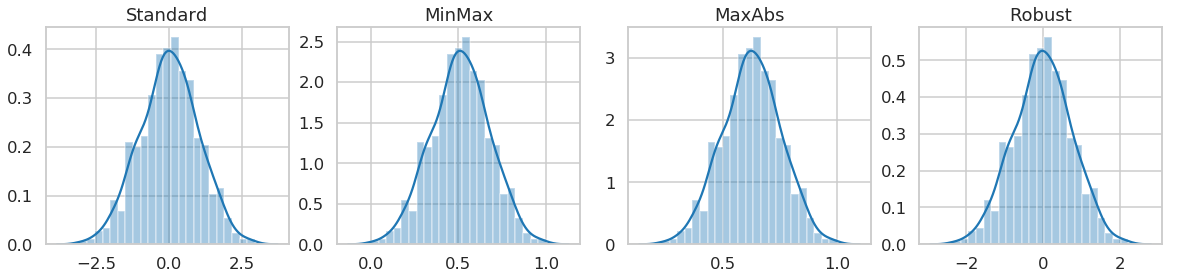

In [16]:
random_state = np.random.RandomState(1289237)
x = random_state.normal(10, 2, size=1000)
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
scalers = {
    'Standard': StandardScaler(),
    'MinMax': MinMaxScaler(),
    'MaxAbs': MaxAbsScaler(),
    'Robust': RobustScaler()
}
scalernames = ['Standard','MinMax','MaxAbs','Robust']
fig, axes = plt.subplots(1,4, figsize=(20, 4))
for i in range(4):
    x_scaled = scalers[scalernames[i]].fit_transform(x.reshape(-1,1)).ravel()
    sns.distplot(x_scaled, ax=axes[i])
    axes[i].set_title(scalernames[i])

### 模型评估与feature解释指南{#evaluatehelp}

#### 特征选择结果可视化{#clustermap}
使用seaborn的clustermap功能，将挑选出的feature的counts（做过合适的scale）绘制heatmap图并聚类，上方的颜色表示类别，可见同一类被很好的聚在了一起。
![pngs](plots/clustermap.png)

#### 用选出的feature进行分类并绘制ROC曲线{#rocplot}
请特别注意，这里的ROC曲线有其特殊之处。针对我们样本很少的问题，我们不能专门划分出一部分测试集供测试和绘制曲线。我们使用两种方式划分数据集：
- leave one out, 即每轮随机选择一个样本作为validation set，其他样本作为训练集，对validation set进行预测，最终保证每个样本恰好作为validation set一次。
- shuffle split, 即每轮随机选择一些样本作为validation set，其他样本作为训练集，对validation set进行预测，最终每个样本可能在不同轮中一共被预测数次。

- 这样，对于leave one out方法，我们恰好可以将所有样本预测一遍，并绘制出ROC曲线，如下图所示。

- 而对于shuffle split方法，每个样本被预测多次，没法放在一起绘制ROC曲线，但是其每轮都可以单独画一条ROC曲线，下面的图片展示的即为“将各条曲线综合起来”的情况，我们使用阴影区域表示每个点的均值的置信区间。

![pngs](plots/roc.png)
![pngs](plots/roc_cv.png)

#### 用AUC评估挑选不同数量feature的效果{#aucline}
读者可以分析挑选不同数量的feature时模型的拟合效果，评估指标为AUC
![pngs](plots/auc_line.png)

#### 比较不同的模型和参数挑出的feature的差异
图中有颜色的色块儿表示在该参数条件下被选中的feature，可以发现线性模型挑出的feature更相似，而random forest在不同参数设置下挑出的feature比较稳定。
![pngs](plots/compare_models.png)

#### 查看feature的鲁棒性
每一列是一轮测试，可以发现大多数feature在每轮测试中都被挑中，证明这些feature具有很强的鲁棒性，我们可以设置一个阈值，选取在超过50%的轮数中都出现的feature作为最终选择的feature。
![pngs](plots/feature_robustness.png)

#### 利用Venn图分析feature的重合
这里利用Venn图分析了HCC三种类型的数据（full length, peak, peak_iterative）的重合情况，每一个子图是一个模型。

![pngs](plots/selected_features_overlap.png)